## Step 1: Imports and data 

In [1]:
import sys
print(sys.version)


3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]


In [335]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim

## Step 2:  Datasets

In [336]:
snowstorm = pd.read_csv('snowstorm_PA.tsv', sep='\t')
PA_cities_counties = pd.read_csv('PA_cities_counties.tsv', sep='\t')
gdf = gpd.read_file('tl_2021_us_county')
PaMunicipalities = gpd.read_file('PaMunicipalities2022_01')

## Step 3: Copy in some utilities 

In [393]:
def add_area_and_label_coords(some_gdf):
    some_gdf['area'] = some_gdf.area
    some_gdf['coords'] = some_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    some_gdf['coords'] = [coords[0] for coords in some_gdf['coords']]
    return some_gdf
    
def plot_with_labels(some_gdf, ax, name_col=None, field_col=None, **kwargs):
    if field_col is None:
        some_gdf.plot(ax=ax, **kwargs)
    else:
        some_gdf.plot(column=field_col, ax=ax, legend=True, **kwargs)
    if name_col is not None:
        for idx, row in some_gdf.iterrows():
            ax.annotate(text=row[name_col], xy=row['coords'],
                         horizontalalignment='center')

def calc_overall_centroid(some_gdf):
    """
    Use the 'coords' and 'area' columns to estimate an overall centroid
    """
    sum_x = 0.0
    sum_y = 0.0
    sum_area = 0.0
    for idx, row in some_gdf.iterrows():
        coord_x, coord_y = row['coords']
        sum_x += coord_x * row['area']
        sum_y += coord_y * row['area']
        sum_area += row['area']
    centroid_x = sum_x / sum_area
    centroid_y = sum_y / sum_area
    return centroid_x, centroid_y

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees).  All args
    must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

## Step 4: Set up an ortho projection for PA 

In [338]:
#Step 4: Set up an ortho projection for PA
gdf = gdf[gdf.STATEFP=='42']

gdf_geometry = gdf['geometry']
gdf_geometry

19      POLYGON ((-80.27803 40.53674, -80.29151 40.527...
47      POLYGON ((-78.95860 41.52549, -78.95861 41.525...
95      POLYGON ((-77.21159 41.54545, -77.21177 41.545...
108     POLYGON ((-76.59217 40.25428, -76.59214 40.254...
165     POLYGON ((-75.29834 41.36740, -75.29849 41.367...
                              ...                        
3046    POLYGON ((-79.90998 41.85069, -79.90995 41.850...
3054    POLYGON ((-79.82262 41.17309, -79.82448 41.173...
3071    POLYGON ((-75.97241 39.98751, -75.97422 39.984...
3166    POLYGON ((-79.55165 40.60189, -79.55157 40.601...
3206    POLYGON ((-79.22902 40.09781, -79.22988 40.097...
Name: geometry, Length: 67, dtype: geometry

In [369]:
#compute centroids
add_area_and_label_coords(gdf)
centroid_x, centroid_y = calc_overall_centroid(gdf)
print(centroid_x, centroid_y)

#orthographic projection for PA
lat = centroid_y
lon = centroid_x
ortho = CRS.from_proj4("+proj=ortho +lat_0={} +lon_0={} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs".format(lat, lon))
ortho_gdf = gdf.to_crs(ortho)
ortho_crs = ortho_gdf.crs

-77.84058346055701 40.900430189750736


/var/folders/q7/c7_w048s46z5fvk1pz07pvzm0000gn/T/ipykernel_24967/3284357153.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area


##  Step 5: Estimate some county-wide snowfall numbers

In [360]:
merged_df = PA_cities_counties.merge(snowstorm, left_on='Name', right_on='Location', how='right')
merged_df

,Name,Type,County,Class,Population (2018 Estimates),Incorporation date (as city),Sq Miles,Location,Low End Snowfall,Expected Snowfall,High End Snowfall,"P>=0.1""","P>=1""","P>=2""","P>=4""","P>=6""","P>=8""","P>=12""","P>=18"""
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bethel Park,8,12,15,100%,100%,100%,98%,94%,83%,40%,1%
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Franklin Park,8,13,16,100%,100%,100%,99%,96%,88%,51%,3%
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jefferson Hills,7,11,14,100%,100%,100%,98%,93%,80%,31%,1%
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monroeville,7,10,14,100%,100%,100%,99%,94%,81%,32%,1%
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moon/Pittsburgh Intl Airport,9,13,16,100%,100%,100%,99%,97%,91%,56%,4%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ligonier,7,9,12,100%,100%,100%,100%,94%,71%,14%,0%
89,Lower Burrell,City,Westmoreland,Third,11228.0,1959.0,11.26,Lower Burrell,7,10,14,100%,100%,100%,99%,95%,82%,32%,1%
90,Monessen,City,Westmoreland,Third,7339.0,1921.0,2.89,Monessen,7,10,13,100%,100%,100%,99%,93%,76%,26%,1%
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Murrysville,7,10,14,100%,100%,100%,99%,96%,82%,31%,1%


In [361]:
number_of_nans = merged_df['County'].isna().sum()
number_of_nans

77

In [362]:
geolocator = Nominatim(user_agent="ms_das_vis")

In [363]:
#assigning county to snowstorm df
location = merged_df['Location']

for i in range(len(location)):
    if pd.isna(merged_df.at[i, 'County']):
        loc = geolocator.geocode(f"{location[i]}, Pennsylvania, US")
        
        if loc is not None:
            address = loc.address
            address_parts = address.split(',')
            
            for part in address_parts:
                if 'County' in part:
                    county_name = part.strip().split()[0]
                    merged_df.at[i, 'County'] = county_name
                    break  
                    
        else:
            #if county not found, assign County with NaN
            merged_df.at[i, 'County'] = pd.NA  
        


In [365]:
merged1 = merged_df[['County', 'Expected Snowfall']]
grouped_df = merged1.groupby('County')['Expected Snowfall'].mean().reset_index()
grouped_df

,County,Expected Snowfall
0,Allegheny,11.571429
1,Armstrong,9.500000
2,Beaver,12.500000
3,Butler,12.200000
4,Clarion,11.500000
5,Clearfield,10.000000
6,Fayette,9.666667
7,Forest,12.000000
8,Greene,9.800000
9,Huntingdon,9.000000


## Step 6: Merge the snowfall data into the GeoDataFrame

In [366]:
merged_df_with_gdf = gdf.merge(grouped_df, left_on='NAME', right_on='County', how='left')

In [367]:
number_of_nans = merged_df_with_gdf['Expected Snowfall'].isna().sum()
number_of_nans

50

## Step 7: Plot the snowfall map 

<IPython.core.display.Javascript object>


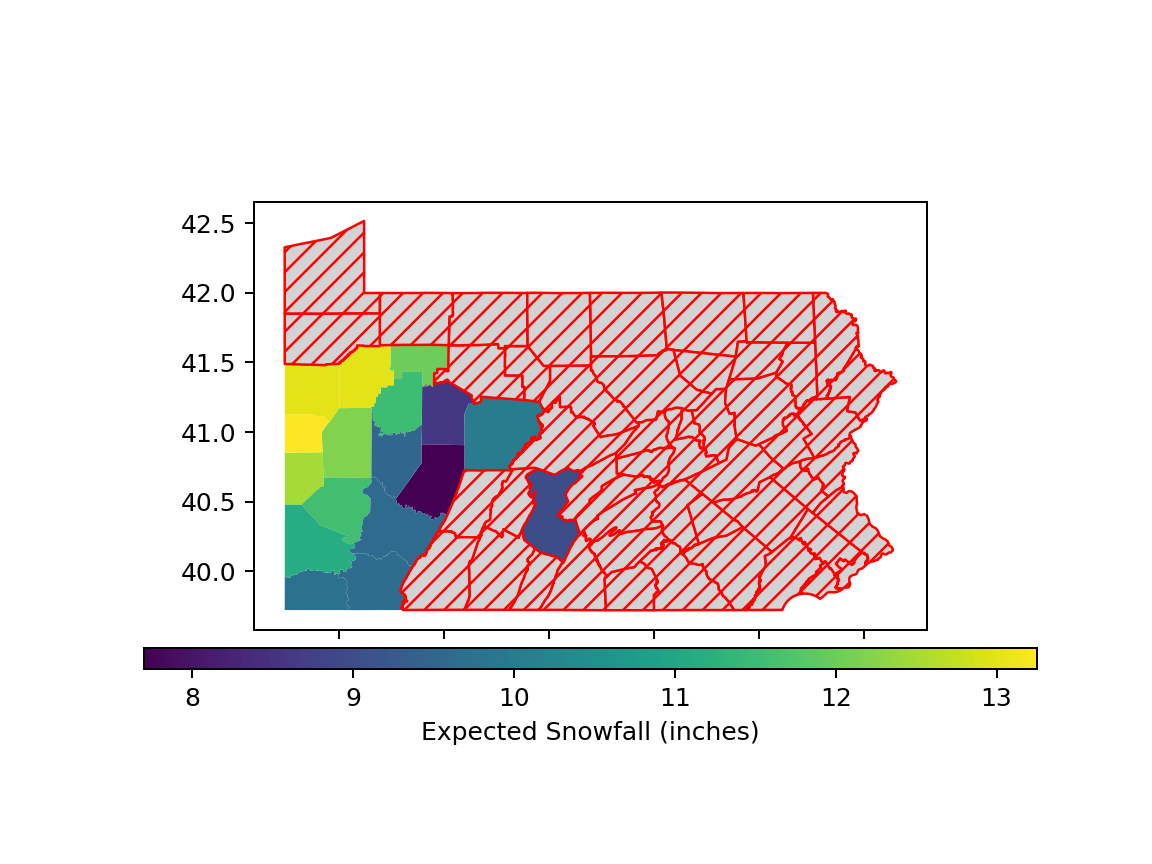

In [368]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.1)
missing_data_color = 'lightgrey' 

merged_df_with_gdf.plot(
    column="Expected Snowfall",
    ax=ax,
    legend=True,
    cax=cax,
    cmap='viridis',
    missing_kwds={
        "color": missing_data_color,  # Use the color defined for missing data
        "edgecolor": "red",           # Optional: Color for the edges of missing data polygons
        "hatch": "///",               # Optional: Pattern for hatching missing data polygons
        "label": "No Data"            # Optional: Label for the legend entry for missing data
    },
    legend_kwds={
        "label": "Expected Snowfall (inches)",  # Label for the color bar
        "orientation": "horizontal"            # Orientation of the color bar
    }
)
plt.show()



## Step 8: Travel distances 

In [409]:
travel_towns = ['Pittsburgh', 'Scranton', 'Allentown', 'Philadelphia', 'Harrisburg','Pittsburgh']
travel_towns_upper = [town.upper() for town in travel_towns]

cities_subset = PaMunicipalities[PaMunicipalities['MUNICIPAL1'].isin(travel_towns_upper)]

# Convert the GeoDataFrame to the Orthographic projection
PaMunicipalities_ortho = PaMunicipalities.to_crs(ortho_crs)
# Convert to Plate Carrée projection (EPSG:4326)
PaMunicipalities_4326 = PaMunicipalities.to_crs('EPSG:4326')

#add area and coord
add_area_and_label_coords(PaMunicipalities_ortho)
add_area_and_label_coords(PaMunicipalities_4326)

/var/folders/q7/c7_w048s46z5fvk1pz07pvzm0000gn/T/ipykernel_24967/4011502844.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area


,MSLINK,COUNTY,MUNICIPAL_,MUNICIPAL1,FIPS_MUN_C,FED_AID_UR,FIPS_COUNT,FIPS_AREA_,FIPS_NAME,FIPS_SQ_MI,...,GIS_UPDATE,GIS_GEOMET,GPID,GEOMETRY_A,GEOMETRY_L,Shape_Leng,Shape_Area,geometry,area,coords
0,2254,59,209,WEST BUFFALO,82640,1,119,00000,None,38.2,...,None,None,33785,0.0,0.0,74680.772799,1.773021e+08,"MULTIPOLYGON (((-77.02752 41.02883, -77.02704 ...",0.010800,"(-77.06442526233276, 41.00826211702454)"
1,1258,21,203,HOPEWELL,35672,1,041,00000,None,28.2,...,None,None,33786,0.0,0.0,55735.307406,1.241206e+08,"POLYGON ((-77.48381 40.12431, -77.48454 40.123...",0.007655,"(-77.56229871986804, 40.15562654353308)"
2,2255,59,210,WHITE DEER,84496,2,119,50016,MILTON,30.6,...,None,None,33787,0.0,0.0,63730.550468,2.107778e+08,"POLYGON ((-76.86164 41.02629, -76.86184 41.025...",0.012826,"(-76.95828271596594, 41.054591140985906)"
3,283,50,407,MILLERSTOWN,49720,1,099,00000,None,1.2,...,None,None,33788,0.0,0.0,10891.156452,4.335253e+06,"POLYGON ((-77.14088 40.55110, -77.14124 40.551...",0.000266,"(-77.15039044058969, 40.554141792238)"
4,2278,60,219,SCRUBGRASS,69016,1,121,00000,None,27.4,...,None,None,33789,0.0,0.0,73267.778096,1.259692e+08,"POLYGON ((-79.71339 41.17668, -79.71347 41.175...",0.007647,"(-79.78989557434501, 41.22586916072269)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2567,1926,05,409,RAINSBURG,63312,1,009,00000,None,0.2,...,None,None,35286,0.0,0.0,4660.742508,7.157302e+05,"POLYGON ((-78.51718 39.89982, -78.51613 39.899...",0.000044,"(-78.51809797628042, 39.896550000220515)"
2568,930,32,209,CHERRYHILL,13072,1,063,00000,None,48.4,...,None,None,35287,0.0,0.0,78591.520019,2.210764e+08,"POLYGON ((-79.05487 40.65022, -79.01865 40.708...",0.013539,"(-79.00112860079133, 40.64379522102561)"
2569,1905,06,231,PIKE,60176,1,011,00000,None,14.3,...,None,None,35288,0.0,0.0,34408.089886,6.235252e+07,"POLYGON ((-75.70435 40.43491, -75.65358 40.402...",0.003832,"(-75.69441581774404, 40.40015107310096)"
2570,1992,04,419,INDUSTRY,36944,4,007,00000,None,9.4,...,None,None,35289,0.0,0.0,44971.557579,4.924139e+07,"POLYGON ((-80.43376 40.68288, -80.41759 40.683...",0.003014,"(-80.40474772221617, 40.65390699658653)"


## Step 9: Travel Map

<IPython.core.display.Javascript object>


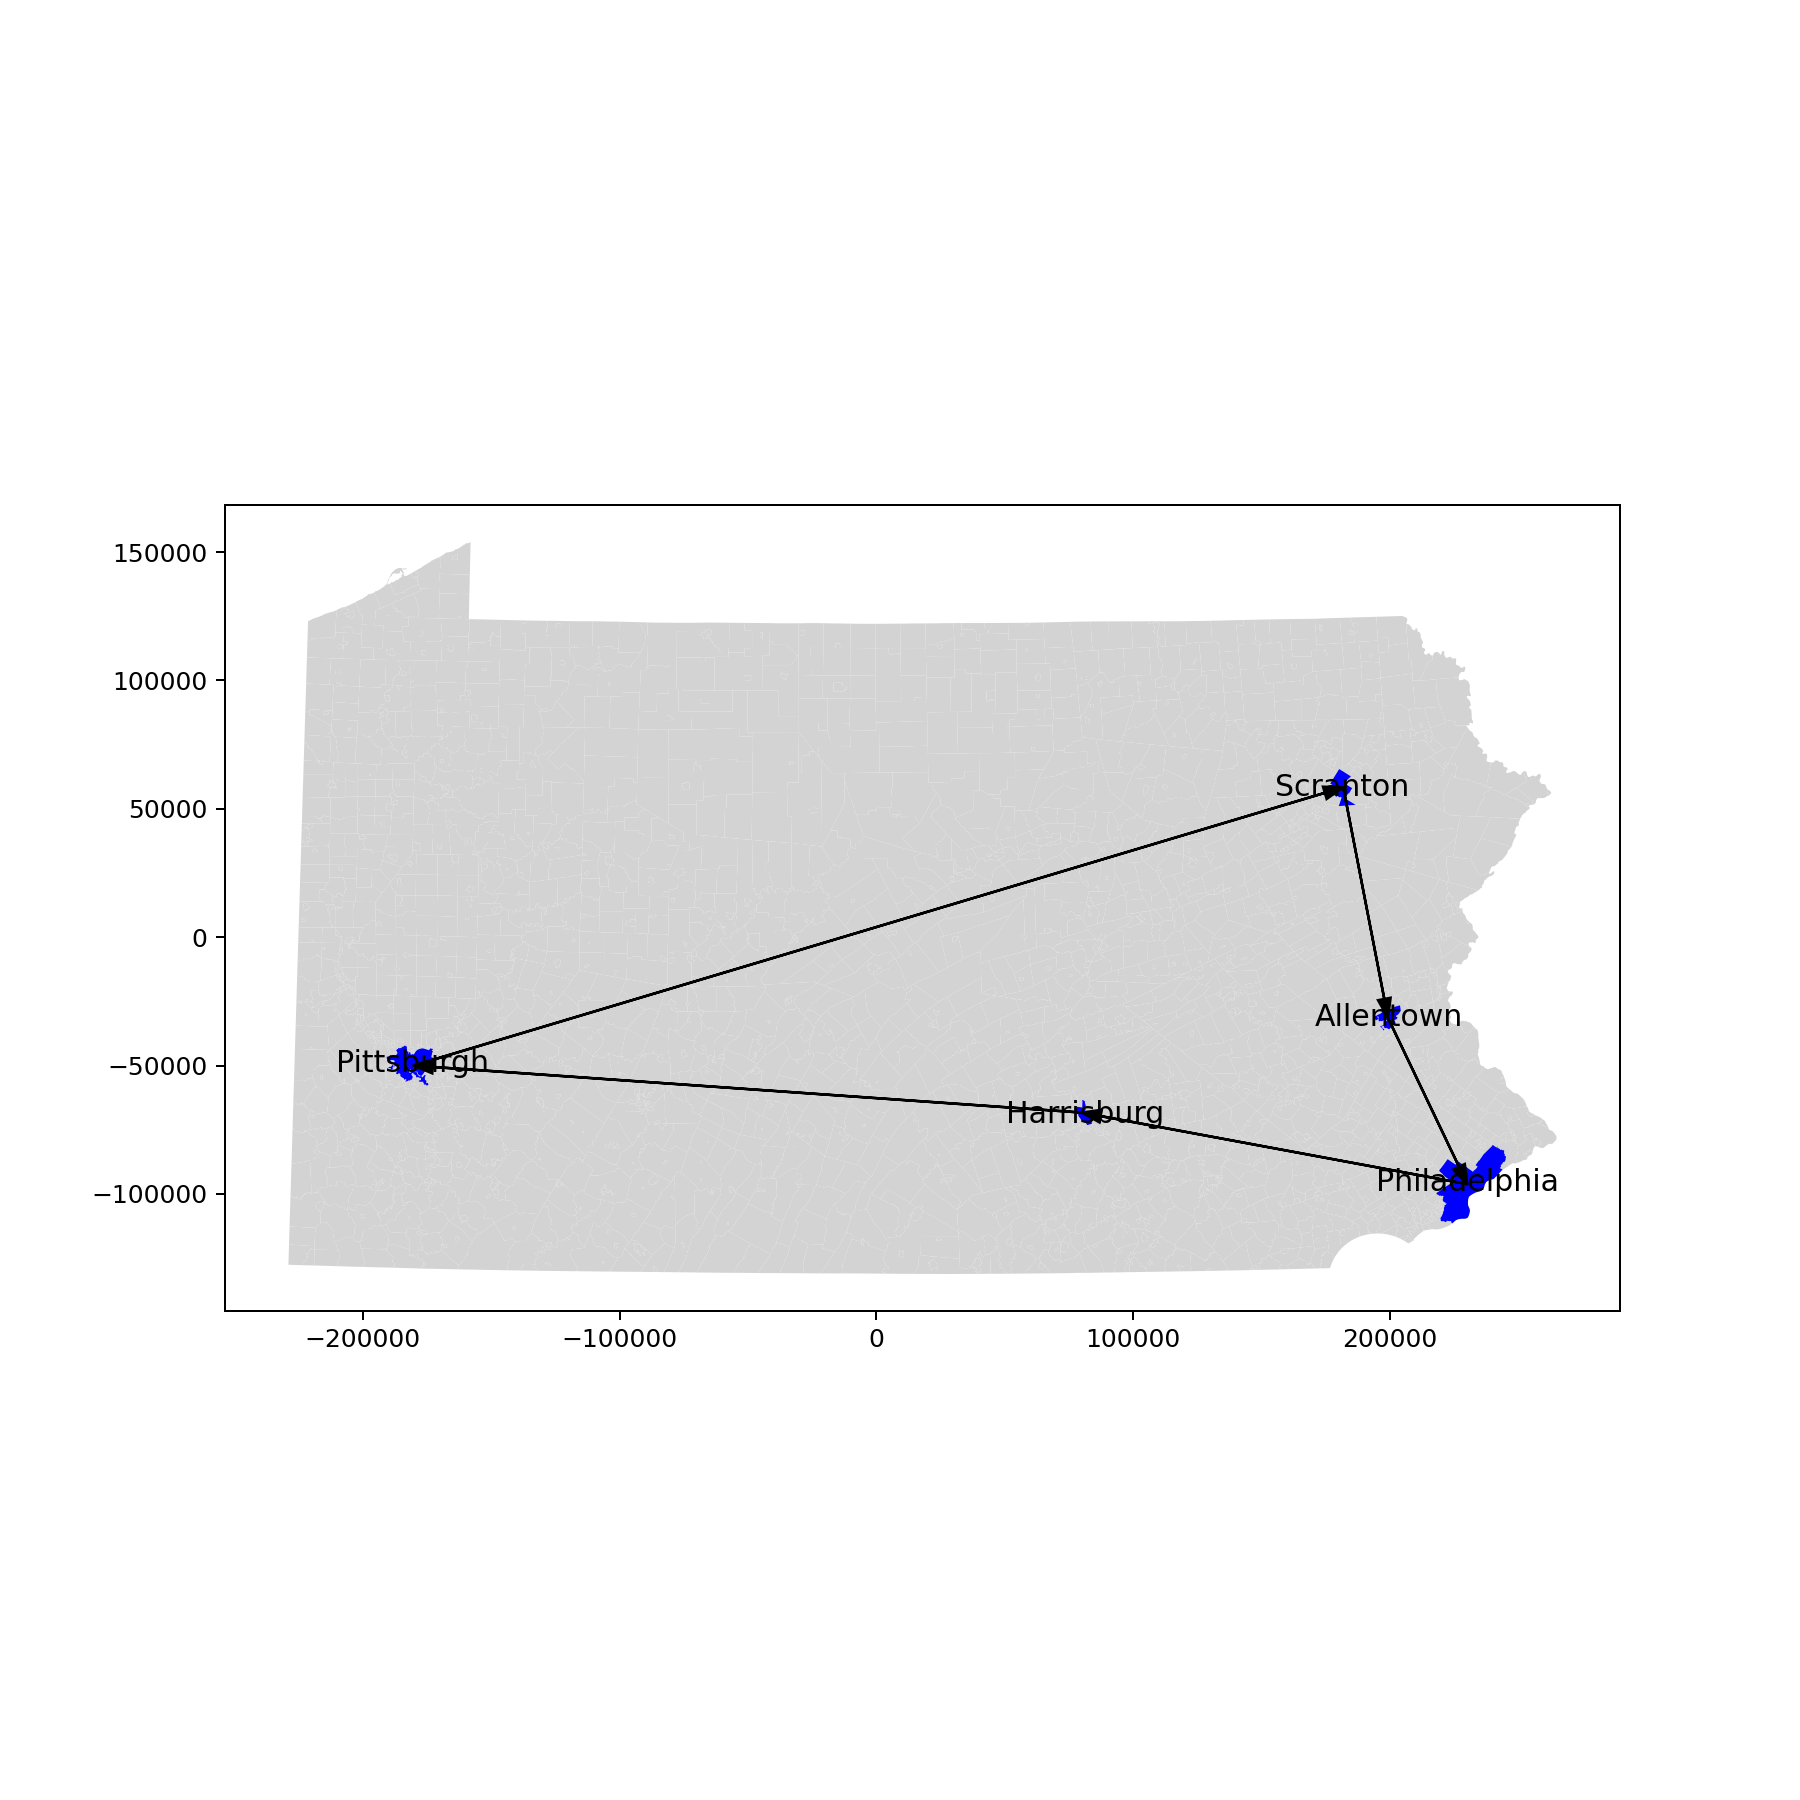

In [410]:
cities_subset = PaMunicipalities_ortho[PaMunicipalities_ortho['MUNICIPAL1'].isin(travel_towns_upper)]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the full PA geometry
PaMunicipalities_ortho.plot(ax=ax, color='lightgrey')  

# Overlay the travel cities with blue
cities_subset.plot(ax=ax, color='blue')  

#base map
for idx, row in cities_subset.iterrows():
    city_name = row['MUNICIPAL1'].title() 
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, city_name, fontsize=12, ha='center', va='center')


for i, town in enumerate(travel_towns[:-1]): 
    start_point = cities_subset.loc[cities_subset['MUNICIPAL1'] == travel_towns_upper[i]].geometry.representative_point().iloc[0]
    end_point = cities_subset.loc[cities_subset['MUNICIPAL1'] == travel_towns_upper[i+1]].geometry.representative_point().iloc[0]
    
    dx = end_point.x - start_point.x
    dy = end_point.y - start_point.y
    ax.arrow(start_point.x, start_point.y, dx, dy, head_width=5000, length_includes_head=True, color='black')

# Show the plot
plt.show()

## Step 10: Loop Travel Distance 

In [413]:
# staright line travel distance for ortho projection
total_distance_ortho = 0

for i, town in enumerate(travel_towns[:-1]):  
    start_point = PaMunicipalities_ortho.loc[PaMunicipalities_ortho['MUNICIPAL1'] == town.upper()].geometry.representative_point().iloc[0]
    end_point = PaMunicipalities_ortho.loc[PaMunicipalities_ortho['MUNICIPAL1'] == travel_towns[i+1].upper()].geometry.representative_point().iloc[0]
    total_distance_ortho += start_point.distance(end_point)
        
total_distance_ortho_in_km = total_distance_ortho/1000
total_distance_ortho_in_km

954.9657630589926

In [412]:
# hacersine distance for Platte Carree projection
total_distance_haversine = 0

for i, town in enumerate(travel_towns[:-1]):  
    start_point = PaMunicipalities_4326.loc[PaMunicipalities_4326['MUNICIPAL1'] == town.upper()].geometry.representative_point().iloc[0]
    end_point = PaMunicipalities_4326.loc[PaMunicipalities_4326['MUNICIPAL1'] == travel_towns[i+1].upper()].geometry.representative_point().iloc[0]
    total_distance_haversine += haversine_np(start_point.x, start_point.y, end_point.x, end_point.y)
    
total_distance_haversine

955.3848741601748

## What are some reasons why the values differ? 

### The computed total_distance_ortho is probably in meters, so I converted it to km to make comparison with the total_distance_haversine. The reasons the values differ is because they used different algorithm to implement the total distance. The first one is using an orthographic projection, where provides a more realistic representation of the actual distances on the Earth's surface.  The second one is using the haversine formula, which assumes a spherical Earth and estimates the shortest distance over the Earth's surface. 

### Furthermore, the GeoSeries.distance() function calculates distances based on the projection's characteristics, which may not accurately reflect the Earth's curvature. The haversine formula, however, directly calculates the great-circle distance between two points on a sphere, providing a more accurate representation of the actual distance.